In [16]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import solid2 as solid
import time
#from numba import jit

import matplotlib.pyplot as plt

## Define a spherical Dot

In [7]:
class InDot:
    def __init__(self,R):
        self.R = R
    
    def __call__(self, r):
        return np.linalg.norm(r) < self.R

In [8]:
a1 = np.array((0,1,1))
a2 = np.array((1,0,1))
a3 = np.array((1,1,0))
dlat = np.array([[0,0,0],[1,0,0]])
Ndot1 = 20
Ndot2 = 20
Ndot3 = 20
indot = InDot(5.1)
ddot = []
for n1 in range(-Ndot1//2,Ndot1//2):
    for n2 in range(-Ndot2//2,Ndot2//2):
        for n3 in range(-Ndot3//2,Ndot3//2):
            for alpha in range(len(dlat)):
                r = n1*a1+n2*a2+n3*a3+dlat[alpha]
                if indot(r):
                    ddot.append(r)
ddot = np.array(ddot)
Ndot = len(ddot)
Ndot

587

In [9]:
min_dist = 10.0
for d1 in ddot:
    for d2 in ddot:
        dist = np.linalg.norm(d1-d2)
        if 0 < dist < min_dist:
            min_dist = dist
min_dist

np.float64(1.0)

In [10]:
model = solid.sphere(0.0)
scale = 10  # Larger scale will use more facets. 
for d in ddot:
    if d.sum() % 2 == 0:
        c = (112/256,128/256,144/256)  # Pb color: blueish-grey
    else:
        c = (150/256,0,0)  # Selenium color: deep red
    model += solid.sphere(scale*0.5).\
        color(c).\
        translate(scale*d)
model.save_as_scad()

'/Users/mlawler/Code/qdotarrays/solid_out.scad'

## Square superlattice of dots

In [11]:
a_dot = 11.0
a1_dot = np.array((a_dot,0,0))
a2_dot = np.array((0,a_dot,0))
D = np.array(ddot)  ## makes a copy of ddot
Dtype = np.array([D[alpha].sum()%2 for alpha in range(len(D))])

In [12]:
min_dist = 10.0
for alpha in range(len(D)):
    for beta in range(len(D)):
        dist = np.linalg.norm(D[alpha] - a1_dot+D[beta])
        min_dist = min(dist,min_dist)
min_dist

np.float64(1.0)

In [13]:
count = 0
for d1 in D:
    for d2 in D:
        if 0.0 < np.linalg.norm(d2-d1) < 1.01:
            count += 1
print(count)

2988


In [17]:
#@jit
def site2index(n1,n2,alpha,N1,N2):
    return n1+n2*N1+alpha*N1*N2
#@jit
def index2site(i,N1,N2):
    n1 = i%N1
    n2 = (i//N1)%N2
    alpha = (i//(N1*N2))
    return (n1,n2,alpha)

In [18]:
N1 = 3
N2 = 3
model = solid.sphere(0.0)
scale = 10  # Larger scale will use more facets. 
for i in range(N1*N2*len(D)):
    n1,n2,alpha = index2site(i,N1,N2)
    r = n1*a1_dot+n2*a2_dot+D[alpha]
    
    if Dtype[alpha] == 0:
        c = (112/256,128/256,144/256)  # Pb color: blueish-grey
    else:
        c = (150/256,0,0)  # Selenium color: deep red
    model += solid.sphere(scale*0.5).\
        color(c).\
        translate(scale*r)
model.save_as_scad()

'/Users/mlawler/Code/qdotarrays/solid_out.scad'

## Electronic Structure

### s,p orbital model
I take this model from the nearest neighbor model of "Band gap anomaly and topological properties in lead chalcogenides" by Nie, Xu, Xu, Fang, Chinese Physics B 2016:

https://iopscience.iop.org/article/10.1088/1674-1056/25/3/037311/meta

In [20]:
N1 = 2
N2 = 2
Nd = len(D)
Norb = 4
S = sparse.dok_matrix((N1*N2*Nd*Norb, N1*N2*Nd*Norb),dtype=np.complex128)

Let's treat the orbitals as first Nd values of alpha are s orbitals, next Nd values are px, next Nd values are py and last Nd values are pz. The onsite and nearest neighbor parameters are:

In [21]:
mu = 5.0
A1 = -2.0072
A2 = 0.0891
A3 = -0.0215 
A6 = 6.9910 
A7 = -0.0259 
A8 = -0.0283 
A9 = 0.3110 
C1 = -7.8493
C2 = -0.0848
C3 = 0.1689
C6 = 3.1139
C7 = 0.1686
C8 = -0.0188
C9 = 0.1356
B1 = -0.1537
B2 = 0.0974
B4 = 0.4891
B5 = 0.1050
E1 = -0.2215
E2 = -0.1308
E4 = 0.1409
E5 = 0.0330
D1 = -0.6076
D2 = 1.2714
D3 = -1.4507
D4 = 1.8474
D5 = -0.2950
F1 = 0.3100
F2 = -0.0491
F3 = -0.0069
F4 = 0.1013
F5 = 0.0425

Block Hamiltonian is then:

In [23]:
#@jit
def hfull(kx,ky,kz):
    H11 = A1 +4*A2*(np.cos(kx)*np.cos(ky) +np.cos(ky)*np.cos(kz) +np.cos(kz)*np.cos(kx)) +2*B1*(np.cos(2*kx) +np.cos(2*ky) +np.cos(2*kz))
    H15 = 2*D1*(np.cos(kx) +np.cos(ky) +np.cos(kz)) +8*F1*np.cos(kx)*np.cos(ky)*np.cos(kz)
    H22 = A6 +4*A7*np.cos(kx)*(np.cos(ky) +np.cos(kz)) +4*A8*np.cos(ky)*np.cos(kz) +2*B4*np.cos(2*kx) +2*B5*(np.cos(2*ky) +np.cos(2*kz))
    H23 = -4*A9*np.sin(kx)*np.sin(ky)
    H24 = -4*A9*np.sin(kx)*np.sin(kz)
    H26 = 2*D4*np.cos(kx) +2*D5*(np.cos(ky) +np.cos(kz)) +8*F4*np.cos(kx)*np.cos(ky)*np.cos(kz)
    H27 = -8*F5*np.sin(kx)*np.sin(ky)*np.cos(kz)
    H28 = -8*F5*np.sin(kx)*np.sin(kz)*np.cos(ky)
    H33 = A6 +4*A7*np.cos(ky)*(np.cos(kz) +np.cos(kx)) +4*A8*np.cos(kz)*np.cos(kx) +2*B4*np.cos(2*ky) +2*B5*(np.cos(2*kz) +np.cos(2*kx))
    H34 = -4*A9*np.sin(ky)*np.sin(kz)
    H36 = H27
    H37 = 2*D4*np.cos(ky) +2*D5*(np.cos(kz) +np.cos(kx)) +8*F4*np.cos(kx)*np.cos(ky)*np.cos(kz)
    H38 = -8*F5*np.sin(ky)*np.sin(kz)*np.cos(kx)
    H44 = A6 +4*A7*np.cos(kz)*(np.cos(kx) +np.cos(ky)) +4*A8*np.cos(kx)*np.cos(ky) +2*B4*np.cos(2*kz) +2*B5*(np.cos(2*kx) +np.cos(2*ky))
    H46 = H28
    H47 = H38
    H48 = 2*D4*np.cos(kz) +2*D5*(np.cos(ky) +np.cos(kx)) +8*F4*np.cos(kx)*np.cos(ky)*np.cos(kz)
    H55 = C1 +4*C2*(np.cos(kx)*np.cos(ky) +np.cos(ky)*np.cos(kz) +np.cos(kz)*np.cos(kx)) +2*E1*(np.cos(2*kx) +np.cos(2*ky) +np.cos(2*kz))
    H66 = C6 +4*C7*np.cos(kx)*(np.cos(ky) +np.cos(kz)) +4*C8*np.cos(ky)*np.cos(kz) +2*E4*np.cos(2*kx) +2*E5*(np.cos(2*ky) +np.cos(2*kz))
    H67 = -4*C9*np.sin(kx)*np.sin(ky)
    H68 = -4*C9*np.sin(kx)*np.sin(kz)
    H77 = C6 +4*C7*np.cos(ky)*(np.cos(kz) +np.cos(kx)) +4*C8*np.cos(kz)*np.cos(kx) +2*E4*np.cos(2*ky) +2*E5*(np.cos(2*kz) +np.cos(2*kx))
    H78 = -4*C9*np.sin(ky)*np.sin(kz)
    H88 = C6 +4*C7*np.cos(kz)*(np.cos(kx) +np.cos(ky)) +4*C8*np.cos(kx)*np.cos(ky) +2*E4*np.cos(2*kz) +2*E5*(np.cos(2*kx) +np.cos(2*ky))

    G12 = 1.0j*(-4*A3*np.sin(kx)*(np.cos(ky) +np.cos(kz))-2*B2*np.sin(2*kx))
    G13 = 1.0j*(-4*A3*np.sin(ky)*(np.cos(kz) +np.cos(kx))-2*B2*np.sin(2*ky))
    G14 = 1.0j*(-4*A3*np.sin(kz)*(np.cos(kx) +np.cos(ky))-2*B2*np.sin(2*kz))
    G16 = 1.0j*(2*D2*np.sin(kx) +8*F3*np.sin(kx)*np.cos(ky)*np.cos(kz))
    G17 = 1.0j*(2*D2*np.sin(ky) +8*F3*np.sin(ky)*np.cos(kz)*np.cos(kx))
    G18 = 1.0j*(2*D2*np.sin(kz) +8*F3*np.sin(kz)*np.cos(kx)*np.cos(ky))
    G25 = 1.0j*(-2*D3*np.sin(kx)-8*F2*np.sin(kx)*np.cos(ky)*np.cos(kz))
    G35 = 1.0j*(-2*D3*np.sin(ky)-8*F2*np.sin(ky)*np.cos(kz)*np.cos(kx))
    G45 = 1.0j*(-2*D3*np.sin(kz)-8*F2*np.sin(kz)*np.cos(kx)*np.cos(ky))
    G56 = 1.0j*(-4*C3*np.sin(kx)*(np.cos(ky) +np.cos(kz))-2*E2*np.sin(2*kx))
    G57 = 1.0j*(-4*C3*np.sin(ky)*(np.cos(kz) +np.cos(kx))-2*E2*np.sin(2*ky))
    G58 = 1.0j*(-4*C3*np.sin(kz)*(np.cos(kx) +np.cos(ky))-2*E2*np.sin(2*kz))
    return np.array([[H11, G12, G13, G14, H15, G16, G17, G18],
                    [-G12, H22, H23, H24, G25, H26, H27, H28],
                    [-G13, H23, H33, H34, G35, H36, H37, H38],
                    [-G14, H24, H34, H44, G45, H46, H47, H48],
                    [ H15,-G25,-G35,-G45, H55, G56, G57, G58],
                    [-G16, H26, H36, H46,-G56, H66, H67, H68],
                    [-G17, H27, H37, H47,-G57, H67, H77, H78],
                    [-G18, H28, H38, H48,-G58, H68, H78, H88]]) - mu*np.eye(8)

In [24]:
R111 = np.array([[1,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0]])
R111

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0]])

In [25]:
hfull(0.1,0.2,0.3)-R111.T@hfull(0.3,0.1,0.2)@R111

array([[ 0.00000000e+00+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
        -0.00000000e+00+0.j, -4.44089210e-16+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         6.93889390e-18+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j, -3.46944695e-18+0.j],
       [ 0.00000000e+00+0.j,  6.93889390e-18+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -3.46944695e-18+0.j,  0.00000000e+00+0.j],
       [-4.44089210e-16+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
        -0.00000000e+00+0.j,  0.00000000e+00+0.j, -0.00000000e+00+0.j,
        -0.00000000e+00+0.j, -0.00000000e+00+0.j],
       [-0.00000000e+00+0.j,  0.000

### K-space view of the model

In [26]:
b1 = np.pi*np.array([-1,1,1])
b2 = np.pi*np.array([1,-1,1])
b3 = np.pi*np.array([1,1,-1])

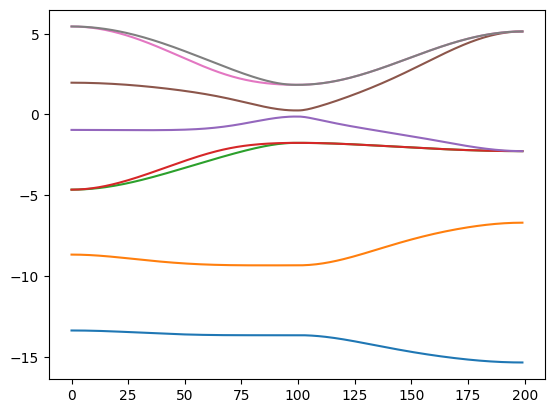

In [28]:
ks = np.linspace(0,1,100)
lams = np.zeros((200,8))
L = (b1+b2+b3)/2
W = (1/4)*b1+(3/4)*b2+(1/2)*b3
for i,k in enumerate(ks):
    kvec = W + k*(L-W)
    lams[i] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = L+k*(-L)
    lams[i+100] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
plt.plot(lams);

In [29]:
(lams[100,5],lams[100,4],lams[100,5]-lams[100,4])

(np.float64(0.25033906112159665),
 np.float64(-0.12828940205927553),
 np.float64(0.3786284631808722))

In [30]:
psi = np.random.rand(8)+1.0j*np.random.rand(8)
psi = psi/np.sqrt(np.linalg.norm(psi))
V[:,5].conj()@hfull(k2[0],k2[1],k2[2])@V[:,5]

NameError: name 'V' is not defined

In [31]:
xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])
L=(b1)/2  # (Choose one of the L points, b1/2, b2/2, b3/2, or (b1+b2+b3)/2)
m,V = np.linalg.eigh(hfull(L[0],L[1],L[2]))
bands = [4,5]
print('zero derivatives (mass terms):')
print(np.array([[V[:,i].conj()@hfull(L[0],L[1],L[2])@V[:,j] for i in bands] for j in bands]))
print('first derivatives: x,y and z:')
delkx = 0.00000001*xhat
print('x: ',np.array([[V[:,i].conj()@((hfull((L+delkx)[0],(L+delkx)[1],(L+delkx)[2])-\
                                       hfull(L[0],L[1],L[2]))/np.linalg.norm(delkx))@V[:,j] for i in bands] for j in bands]))
delky = 0.00000001*yhat
print('y: ',np.array([[V[:,i].conj()@((hfull((L+delky)[0],(L+delky)[1],(L+delky)[2])-\
                                       hfull(L[0],L[1],L[2]))/np.linalg.norm(delky))@V[:,j] for i in bands] for j in bands]))
delkz = 0.00000001*zhat
print('z: ',np.array([[V[:,i].conj()@((hfull((L+delkz)[0],(L+delkz)[1],(L+delkz)[2])-\
                                       hfull(L[0],L[1],L[2]))/np.linalg.norm(delkz))@V[:,j] for i in bands] for j in bands]))
print('second derivatives: xx,yy,zz,xy,yz,zx:')
print('xx: ',np.array([[V[:,i].conj()@((hfull((L+delkx)[0],(L+delkx)[1],(L+delkx)[2])-\
                                        2*hfull(L[0],L[1],L[2])+\
                                        hfull((L-delkx)[0],(L-delkx)[1],(L-delkx)[2]))/np.linalg.norm(delkx)**2)@V[:,j] 
                                            for i in bands] for j in bands]))
print('yy: ',np.array([[V[:,i].conj()@((hfull((L+delky)[0],(L+delky)[1],(L+delky)[2])-\
                                        2*hfull(L[0],L[1],L[2])+\
                                        hfull((L-delky)[0],(L-delky)[1],(L-delky)[2]))/np.linalg.norm(delky)**2)@V[:,j] 
                                            for i in bands] for j in bands]))
print('zz: ',np.array([[V[:,i].conj()@((hfull((L+delkz)[0],(L+delkz)[1],(L+delkz)[2])-\
                                        2*hfull(L[0],L[1],L[2])+\
                                        hfull((L-delkz)[0],(L-delkz)[1],(L-delkz)[2]))/np.linalg.norm(delkz)**2)@V[:,j] 
                                            for i in bands] for j in bands]))
print('xy: ',np.array([[V[:,i].conj()@((hfull((L+delkx+delky)[0],(L+delkx+delky)[1],(L+delkx+delky)[2])-\
                                        hfull((L+delkx-delky)[0],(L+delkx-delky)[1],(L+delkx-delky)[2])-\
                                        hfull((L-delkx+delky)[0],(L-delkx+delky)[1],(L-delkx+delky)[2])+\
                                        hfull((L-delkx-delky)[0],(L-delkx-delky)[1],(L-delkx-delky)[2]))/\
                                        np.linalg.norm(delkx)/np.linalg.norm(delky))@V[:,j] 
                                            for i in bands] for j in bands]))
print('yz: ',np.array([[V[:,i].conj()@((hfull((L+delky+delkz)[0],(L+delky+delkz)[1],(L+delky+delkz)[2])-\
                                        hfull((L+delky-delkz)[0],(L+delky-delkz)[1],(L+delky-delkz)[2])-\
                                        hfull((L-delky+delkz)[0],(L-delky+delkz)[1],(L-delky+delkz)[2])+\
                                        hfull((L-delky-delkz)[0],(L-delky-delkz)[1],(L-delky-delkz)[2]))/\
                                        np.linalg.norm(delky)/np.linalg.norm(delkz))@V[:,j] 
                                            for i in bands] for j in bands]))
print('zx: ',np.array([[V[:,i].conj()@((hfull((L+delkz+delkx)[0],(L+delkz+delkx)[1],(L+delkz+delkx)[2])-\
                                        hfull((L+delkz-delkx)[0],(L+delkz-delkx)[1],(L+delkz-delkx)[2])-\
                                        hfull((L-delkz+delkx)[0],(L-delkz+delkx)[1],(L-delkz+delkx)[2])+\
                                        hfull((L-delkz-delkx)[0],(L-delkz-delkx)[1],(L-delkz-delkx)[2]))/\
                                        np.linalg.norm(delkx)/np.linalg.norm(delky))@V[:,j] 
                                            for i in bands] for j in bands]))

zero derivatives (mass terms):
[[-1.28289402e-01+0.00000000e+00j -1.43945780e-16-6.68993496e-17j]
 [-1.43945780e-16+6.68993496e-17j  2.50339061e-01-2.77555756e-16j]]
first derivatives: x,y and z:
x:  [[ 8.67036957e-17-2.37389194e-66j -7.33560251e-01-3.62397555e-01j]
 [-7.33560251e-01+3.62397555e-01j  2.50414242e-08-3.30872245e-24j]]
y:  [[-8.67036957e-17+0.00000000e+00j  7.33560251e-01+3.62397555e-01j]
 [ 7.33560251e-01-3.62397555e-01j  2.50414244e-08-1.65436123e-24j]]
z:  [[-8.67036957e-17+4.74778387e-66j  7.33560251e-01+3.62397555e-01j]
 [ 7.33560251e-01-3.62397555e-01j  2.50414242e-08+1.65436123e-24j]]
second derivatives: xx,yy,zz,xy,yz,zx:
xx:  [[-4.29724023e-24+3.53737464e-74j  1.71111250e-08+8.45333409e-09j]
 [ 1.71111250e-08-8.45333409e-09j  5.00828485e+00+2.22044605e-16j]]
yy:  [[-4.29724023e-24-7.07474928e-74j  1.71111250e-08+8.45333409e-09j]
 [ 1.71111250e-08-8.45333409e-09j  5.00828485e+00-2.22044605e-16j]]
zz:  [[-2.69387145e-24+8.84343660e-75j  1.01862194e-08+5.03225333e-0

In [32]:
a = 1.43313728
b = 8.18194738e-01
c = 0*5.00828485
E0 = (-1.28289402e-01+2.50339061e-01)/2
m = (-1.28289402e-01-2.50339061e-01)/2
hL = lambda k0,k1,k2: np.array([[E0+m,
                                 a*(k0-L[0])+b*(k1-L[1])+b*(k2-L[2])],
                                [a*(k0-L[0])+b*(k1-L[1])+b*(k2-L[1]),
                                 E0-m+c*((k0-L[0])**2+(k1-L[1])**2+(k2-L[2])**2)]])

In [33]:
a1

array([0, 1, 1])

In [34]:
(np.array([-a,b,b])@a1/(2*np.pi),np.array([-a,b,b])@a2/(2*np.pi),np.array([-a,b,b])@a3/(2*np.pi))

(np.float64(0.26043947392895644),
 np.float64(-0.09787114527679545),
 np.float64(-0.09787114527679545))

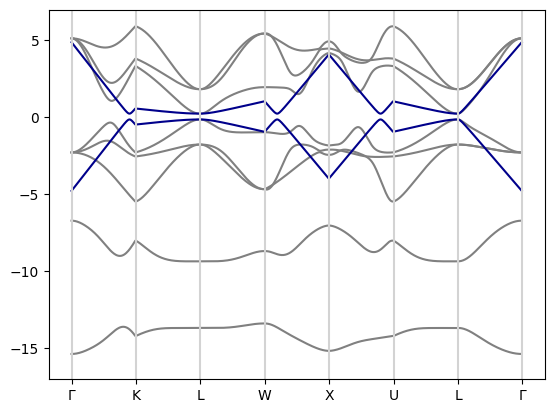

In [35]:
ks = np.linspace(0,1,100)
lams = np.zeros((700,8))
lamsL = np.zeros((700,2))
Gamma = np.array([0,0,0])
K = (3/8)*b1+(3/4)*b2+(3/8)*b3
L = (b1+b2+b3)/2
W = (1/4)*b1+(3/4)*b2+(1/2)*b3
X = np.array([0,0.5,0.5])
U = (1/4)*b1+(5/8)*b2+(5/8)*b3
for i,k in enumerate(ks):
    kvec = Gamma + k*(K-Gamma)
    lams[i] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = K + k*(L-K)
    lams[i+100] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+100] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = L + k*(W-L)
    lams[i+200] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+200] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = W+k*(X-W)
    lams[i+300] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+300] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = X+k*(U-X)
    lams[i+400] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+400] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = U+k*(L-U)
    lams[i+500] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+500] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
for i,k in enumerate(ks):
    kvec = L+k*(Gamma-L)
    lams[i+600] = np.linalg.eigvalsh(hfull(kvec[0],kvec[1],kvec[2]))
    lamsL[i+600] = np.linalg.eigvalsh(hL(kvec[0],kvec[1],kvec[2]))
fig, ax = plt.subplots()
ax.plot(lams,color='gray');
ax.plot(lamsL,color='darkblue');
ax.vlines([0,100,200,300,400,500,600,700],-17,7,color='lightgray')
#ax.axis('off')
ax.set_xticks([0,100,200,300,400,500,600,700])
ax.set_xticklabels(['Γ','K','L','W','X','U','L','Γ']);
plt.ylim([-17,7]);

In summary, we can take our effective Hamiltonian to be:

$$
\bar\psi\left[\sigma_x (ai\partial_x + bi\partial_y + bi\partial_z) + m\sigma_z\right]\psi
$$

In [253]:
(b3)/2

array([ 1.57079633,  1.57079633, -1.57079633])

### Real space view of model

In [36]:
start = time.time()
#@jit
def neighborlists(N1,N2,Nd,Norb):
    nnlist = np.zeros((50*N1*N2*Nd*Norb,2))
    nnnlist = np.zeros((50*N1*N2*Nd*Norb,2))
    nnnnlist = np.zeros((50*N1*N2*Nd*Norb,2))
    nn,nnn,nnnn=0,0,0
    for i in range(N1*N2*Nd*Norb):
        n1,n2,alpha = index2site(i,N1,N2)
        r = n1*a1_dot+n2*a2_dot+D[alpha%Nd]
        coupled = 0
        if i == 2378:
            print('i made it to 2378')
        for j in range(N1*N2*Nd*Norb):
            n1p,n2p,alphap = index2site(j,N1,N2)
            rp = n1p*a1_dot+n2p*a2_dot+D[alphap%Nd]
            if i == 2378 and j == 0:
                print('i made it to 2378 and j to 0')
                print('nn = ', nn, 'dr = ',r-rp, ' with len = ',np.linalg.norm(r-rp))
            if abs(np.linalg.norm(r-rp)- 1.0) < 0.1:
                if i==2378 and j == 0:
                    print('Suposedly found [2378,0]')
                nnlist[nn]=np.array([i,j])
                nn+=1
                coupled+=1
            elif abs(np.linalg.norm(r-rp) - np.sqrt(2)) < 0.1:
                nnnlist[nnn]=np.array([i,j])
                nnn+=1
                coupled+=1
            elif abs(np.linalg.norm(r-rp) - np.sqrt(3)) < 0.1:
                nnnnlist[nnnn]=np.array([i,j])
                nnnn+=1
                coupled+=1
            elif abs(np.linalg.norm(r-rp) - 2.0) < 0.1:
                nnnnlist[nnnn]=np.array([i,j])
                nnnn+=1
                coupled+=1
        if coupled==0:
            print('atom ', i, n1, n2, alpha%Nd, ' not coupled to anything!')
    nnlist = nnlist[:nn]
    nnnlist = nnnlist[:nnn]
    nnnnlist = nnnnlist[:nnnn]
    return nnlist,nnnlist,nnnnlist
nnlist,nnnlist,nnnnlist = neighborlists(N1,N2,Nd,Norb)
nnlist,nnnlist,nnnnlist = nnlist.astype(int),nnnlist.astype(int),nnnnlist.astype(int)
print('nn = ', len(nnlist), ', nnn = ', len(nnnlist), ', nnnn = ',len(nnnnlist))
print('Time taken to complete this task: ',time.time()-start)

i made it to 2378
i made it to 2378 and j to 0
nn =  48328 dr =  [ 1. 10.  2.]  with len =  10.246950765959598
nn =  191872 , nnn =  361984 , nnnn =  385664
Time taken to complete this task:  883.9719018936157


### Construct model

In [37]:
start = time.time()
def Sonsite():
    for i in range(N1*N2*Nd*Norb):
        n1,n2,alpha = index2site(i,N1,N2)
        orb = alpha//Nd
        typ = Dtype[alpha%Nd]
        if typ==0 and orb == 0:
            S[i,i] = A1-mu
        elif typ==0 and orb > 0:
            S[i,i] = A6-mu
        elif typ==1 and orb == 0:
            S[i,i] = C1-mu
        elif typ==1 and orb > 0:
            S[i,i] = C6-mu
        else:
            print('index ', i,' with type ', typ, ' and orbital ', orb, ' is dropped!')
Sonsite()
print('Time taken to complete this task: ',time.time()-start)

Time taken to complete this task:  0.05778980255126953


In [38]:
start = time.time()
ehat = np.array([[1,0,0],[0,1,0],[0,0,1]])
countnntypes=np.zeros((2,2))
def Snn():
    for i,j in nnlist:
        n1,n2,alpha = index2site(i,N1,N2)
        n1p,n2p,alphap = index2site(j,N1,N2)

        dr = (n1-n1p)*a1_dot+(n2-n2p)*a2_dot+D[alpha%Nd]-D[alphap%Nd]
        iorb = alpha//Nd
        itype = Dtype[alpha%Nd]
        jorb = alphap//Nd
        jtype = Dtype[alphap%Nd]
        countnntypes[itype,jtype]+=1
        
        # In the following, there is a symmetry distinction between (px-py, px-pz) and py-pz
        # Check the signs: especially for A3 and A9
        if itype == 0 and jtype == 0: #Scale up the cos(2kx)-like terms
            if iorb == 0 and jorb == 0: ## s-s C-C coupling
                S[i, j] = 10*B1
            elif iorb == 0 and jorb > 0: ## s-p C-C coupling
                S[i,j] = 10.0j*B2
            elif iorb >0 and jorb == 0: ## p-s C-C coupling
                S[i,j] = -10.0j*B2
            elif iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-C coupling
                if abs(dr@ehat[iorb-1])==1:
                    S[i,j] = 10*B4
                else:
                    S[i,j] = 10*B5
        if itype == 1 and jtype == 1: #Scale up the cos(2kx)-like terms
            if iorb == 0 and jorb == 0: ## s-s A-A coupling
                S[i, j] = 10*E1
            elif iorb == 0 and jorb > 0: ## s-p A-A coupling
                S[i,j] = 10.0j*E2
            elif iorb >0 and jorb == 0: ## p-s A-A coupling
                S[i,j] = -10.0j*E2
            elif iorb >0 and jorb >0 and iorb==jorb:  ## p-p A-A coupling
                if abs(dr@ehat[iorb-1])==1:
                    S[i,j] = 10*E4
                else:
                    S[i,j] = 10*E5
            
        if itype == 0 and jtype == 1:
            if iorb == 0 and jorb == 0: ## s-s C-A coupling
                S[i, j] = D1
            elif iorb == 0 and jorb > 0: ## s-p C-A coupling
                S[i,j] = 1.0j*D2
            elif iorb >0 and jorb == 0: ## p-s C-A coupling
                S[i,j] = -1.0j*D3
            elif iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-A coupling
                if abs(dr@ehat[iorb-1])==1:
                    S[i,j] = D4
                else:
                    S[i,j] = D5

        if itype == 1 and jtype == 0:
            if iorb == 0 and jorb == 0: ## s-s A-C coupling
                S[i, j] = D1
            elif iorb == 0 and jorb > 0: ## s-p A-C coupling
                S[i,j] = -1.0j*D2
            elif iorb >0 and jorb == 0: ## p-s A-C coupling
                S[i,j] = 1.0j*D3
            elif iorb >0 and jorb >0 and iorb==jorb:  ## p-p A-C coupling
                if abs(dr@ehat[iorb-1])==1:
                    S[i,j] = D4
                else:
                    S[i,j] = D5
Snn()
print('Time taken to complete this task: ',time.time()-start)

Time taken to complete this task:  1.428920030593872


In [39]:
start = time.time()
ehat = np.array([[1,0,0],[0,1,0],[0,0,1]])
def Snnn():
    for i,j in nnnlist:
        n1,n2,alpha = index2site(i,N1,N2)
        n1p,n2p,alphap = index2site(j,N1,N2)

        dr = (n1-n1p)*a1_dot+(n2-n2p)*a2_dot+D[alpha%Nd]-D[alphap%Nd]
        iorb = alpha//Nd
        itype = Dtype[alpha%Nd]
        jorb = alphap//Nd
        jtype = Dtype[alphap%Nd]

        # In the following, there is a symmetry distinction between (px-py, px-pz) and py-pz
        # Check the signs: especially for A3 and A9
        if itype == 0 and jtype == 0:
            if iorb == 0 and jorb == 0: ## s-s C-C coupling
                S[i, j] = A2
            if iorb == 0 and jorb > 0: ## s-p C-C coupling
                S[i,j] = 1.0j*A3
            if iorb >0 and jorb == 0: ## p-s C-C coupling
                S[i,j] = -1.0j*A3
            if iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-C coupling
                if dr@ehat[iorb-1]==0:
                    S[i,j] = A7
                else:
                    S[i,j] = A8
            if iorb >0 and jorb >0 and iorb!=jorb:  ## p-p C-C coupling
                S[i,j] = A9
        if itype == 1 and jtype == 1:
            if iorb == 0 and jorb == 0: ## s-s C-C coupling
                S[i, j] = C2
            if iorb == 0 and jorb > 0: ## s-p C-C coupling
                S[i,j] = 1.0j*C3
            if iorb >0 and jorb == 0: ## p-s C-C coupling
                S[i,j] = -1.0j*C3
            if iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-C coupling
                if dr@ehat[iorb-1]==0:
                    S[i,j] = C7
                else:
                    S[i,j] = C8
            if iorb >0 and jorb >0 and iorb!=jorb:  ## p-p C-C coupling
                S[i,j] = C9
Snnn()            
print('Time taken to complete this task: ',time.time()-start)

Time taken to complete this task:  3.118008852005005


In [40]:
start = time.time()
ehat = np.array([[1,0,0],[0,1,0],[0,0,1]])
def Snnnn():
    for i,j in nnnnlist:
        n1,n2,alpha = index2site(i,N1,N2)
        n1p,n2p,alphap = index2site(j,N1,N2)

        dr = (n1-n1p)*a1_dot+(n2-n2p)*a2_dot+D[alpha%Nd]-D[alphap%Nd]
        iorb = alpha//Nd
        itype = Dtype[alpha%Nd]
        jorb = alphap//Nd
        jtype = Dtype[alphap%Nd]

        # In the following, there is a symmetry distinction between (px-py, px-pz) and py-pz
        # Check the signs: especially for A3 and A9
        if np.linalg.norm(dr)==np.sqrt(3):
            if itype == 0 and jtype == 1:
                if iorb == 0 and jorb == 0: ## s-s C-C coupling
                    S[i, j] = F1
                if iorb > 0 and jorb == 0: ## s-p C-C coupling
                    S[i,j] = 1.0j*F2
                if iorb == 0 and jorb > 0: ## s-p C-C coupling
                    S[i,j] = 1.0j*F3
                if iorb >0 and jorb >0:
                    if iorb==jorb:  ## p-p C-C coupling
                        S[i,j] = F4
                    else:
                        S[i,j] = F5                    
                    
            if itype == 1 and jtype == 0:
                if iorb == 0 and jorb == 0: ## s-s C-C coupling
                    S[i, j] = F1
                if iorb > 0 and jorb == 0: ## s-p C-C coupling
                    S[i,j] = -1.0j*F2
                if iorb == 0 and jorb > 0: ## s-p C-C coupling
                    S[i,j] = -1.0j*F3
                if iorb >0 and jorb >0:
                    if iorb==jorb:  ## p-p C-C coupling
                        S[i,j] = F4
                    else:
                        S[i,j] = F5                    
        
        if np.linalg.norm(dr)==2.0:
            if itype == 0 and jtype == 0:
                if iorb == 0 and jorb == 0: ## s-s C-C coupling
                    S[i, j] = B1
                if iorb == 0 and jorb > 0: ## s-p C-C coupling
                    S[i,j] = 1.0j*B2
                if iorb >0 and jorb == 0: ## p-s C-C coupling
                    S[i,j] = -1.0j*B2
                if iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-C coupling
                    if dr@ehat[iorb-1]==0:
                        S[i,j] = B4
                    else:
                        S[i,j] = B5                    
                    
            if itype == 1 and jtype == 1:
                if iorb == 0 and jorb == 0: ## s-s C-C coupling
                    S[i, j] = E1
                if iorb == 0 and jorb > 0: ## s-p C-C coupling
                    S[i,j] = 1.0j*E2
                if iorb >0 and jorb == 0: ## p-s C-C coupling
                    S[i,j] = -1.0j*E2
                if iorb >0 and jorb >0 and iorb==jorb:  ## p-p C-C coupling
                    if dr@ehat[iorb-1]==0:
                        S[i,j] = E4
                    else:
                        S[i,j] = E5
        
Snnn()            
print('Time taken to complete this task: ',time.time()-start)

Time taken to complete this task:  3.1677019596099854


### Compute eigenstates

In [220]:
start = time.time()
lam,V = sparse.linalg.eigsh(S,k=200,sigma=0.0)
print(time.time()-start)

23.93101978302002


In [221]:
lam_l = list(lam)
lam_l.sort()
print(lam_l[40:50])
lam

[-0.03172273639767115, -0.021231290359070308, -0.021231290359070204, -0.018899759422762168, 0.03347596039882498, 0.03359476752865958, 0.03359476752865988, 0.03373693136607967, 0.03584132286716497, 0.038321435593226455]


array([-0.01889976, -0.02123129, -0.02123129, -0.03172274,  0.03347596,
        0.03373693,  0.03584132,  0.03359477,  0.03359477,  0.03832144,
        0.03967077,  0.03898731,  0.03898731,  0.04107077,  0.04107077,
        0.04644247,  0.04522566,  0.04522566,  0.04522566,  0.04522566,
       -0.07583035, -0.1063861 , -0.10086078, -0.10086078, -0.12777273,
       -0.13114665, -0.13114665, -0.14366747, -0.14965497, -0.15626077,
       -0.1537959 ,  0.1187823 , -0.1537959 ,  0.11988235,  0.11929919,
        0.11929919,  0.12455996,  0.12649974,  0.12789823,  0.12823774,
        0.12647573,  0.12647573,  0.12954231,  0.13636069,  0.13070782,
        0.1307787 ,  0.13327722,  0.13166733,  0.12927867,  0.12927867,
        0.12929014,  0.12929014,  0.13409731,  0.13409731,  0.13168724,
        0.13168724,  0.15388739,  0.15498558,  0.15557428,  0.1535937 ,
        0.1535937 ,  0.16812104,  0.16169446,  0.16169446,  0.17398296,
        0.1754715 ,  0.17475789,  0.17477078,  0.1794619 ,  0.17

(array([ 4.,  0., 20.,  4.,  0.,  0.,  8.,  3.,  1.,  4., 11.,  5., 10.,
        22., 16., 20., 16., 21., 15., 20.]),
 array([-0.41891738, -0.37681885, -0.33472032, -0.29262179, -0.25052326,
        -0.20842473, -0.1663262 , -0.12422767, -0.08212914, -0.04003061,
         0.00206792,  0.04416645,  0.08626498,  0.12836351,  0.17046204,
         0.21256057,  0.2546591 ,  0.29675763,  0.33885616,  0.38095469,
         0.42305322]),
 <BarContainer object of 20 artists>)

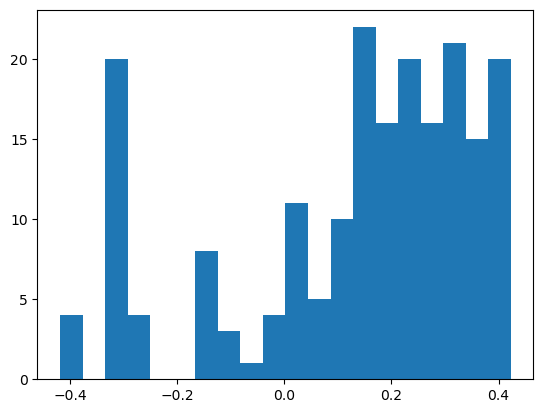

In [39]:
plt.hist(lam,20)

In [74]:
rxmax,rymax = 0.0,0.0
rxmin,rymin = 0.0,0.0
for i in range(N1*N2*Nd):
    n1,n2,alpha = index2site(i,N1,N2)
    r = n1*a1_dot+n2*a2_dot+D[alpha]
    if r[0] > rxmax:
        rxmax = r[0]
    if r[0] < rxmin:
        rxmin = r[0]
    if r[1] > rymax:
        rymax = r[1]
    if r[1] < rymin:
        rymin = r[1]
canvas = np.zeros((int(rxmax-rxmin)+1,int(rymax-rymin)+1))
for i in range(N1*N2*Nd*Norb):
    n1,n2,alpha = index2site(i,N1,N2)
    r = n1*a1_dot+n2*a2_dot+D[alpha%Nd]
    if r[2] == 0.0:
        #print(rxmin+r(0),rymin+r(1))
        canvas[int(r[0]-rxmin),int(r[1]-rymin)] += abs(V[i,0])

In [75]:
lam[13]

0.04107077405996914

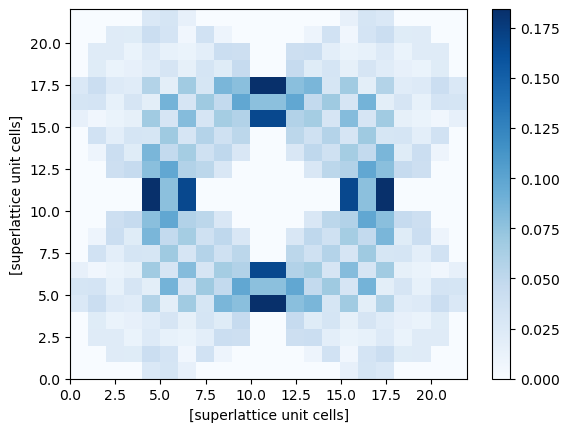

In [76]:
plt.pcolor(canvas.T,cmap='Blues')
plt.colorbar()
plt.xlabel('[superlattice unit cells]')
plt.ylabel('[superlattice unit cells]');

In [ ]:
def heisenberg(theta):
    op = qi.Operator([[exp(1.0j*theta/4),0,0,0],
                      [0,np.cos(theta/4)*np.exp(1.0j*theta/4),np.sin(theta/4),0],
                      [0,np.sin(theta/4),np.cos(theta/4)*np.exp(-1.0j*theta/4),0],
                      [0,0,0,exp(1.0j*theta/4)]])